In [53]:
import os.path
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Dense, Layer
import keras.backend as K
from keras.models import Sequential
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [54]:
datav1 = pd.read_json("C:/51mtech/desertation/data/02.news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json",encoding="utf8",  lines=True)
datav2 = pd.read_json("C:/51mtech/desertation/data/02.news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json",encoding="utf8",  lines=True)

In [55]:
all_data = pd.concat([datav1,datav2])
all_data.info()
all_data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0


In [56]:
all_data.drop(columns={'article_link'}, inplace=True)
all_data.info()
all_data.tail(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      55328 non-null  object
 1   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


,headline,is_sarcastic
28609,bakery owner vows to stop making wedding cakes...,0
28610,congressman picked last for committee on youth...,1
28611,grandmother doesn't care for new priest,1
28612,polish rapper under fire for use of the word '...,1
28613,how san antonio's dominant defense is fueling ...,0
28614,jews to celebrate rosh hashasha or something,1
28615,internal affairs investigator disappointed con...,1
28616,the most beautiful acceptance speech this week...,0
28617,mars probe destroyed by orbiting spielberg-gat...,1
28618,dad clarifies this not a food stop,1


In [57]:
data01 = pd.read_csv('C:/51mtech/desertation/data/01.tweets-with-sarcasm-and-irony/train.csv')
data01_test = pd.read_csv('C:/51mtech/desertation/data/01.tweets-with-sarcasm-and-irony/test.csv')
data01 = data01.append(data01_test)
data01.info()
print(data01.groupby('class').count())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89536 entries, 0 to 8127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  89534 non-null  object
 1   class   89527 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
            tweets
class             
figurative   23282
irony        23005
regular      20454
sarcasm      22786


In [58]:
data01_sarc = data01[data01['class'] == 'sarcasm']
data01_sarc = data01_sarc.append(data01[data01['class'] == 'regular'])

d = {'regular': 0, 'sarcasm': 1}
data01_sarc['is_sarcastic'] = data01_sarc['class'].astype(str).map(d).fillna(data01_sarc['class'])
data01_sarc.drop(columns={'class'}, inplace=True)

data01_sarc.info()

data01_sarc.tail(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43240 entries, 60727 to 6022
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweets        43240 non-null  object
 1   is_sarcastic  43240 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1013.4+ KB


,tweets,is_sarcastic
6013,Meet the Modern Learner! Great #Infographic b...,0
6014,9/30 Free Webinar! Overcoming the Challenge of...,0
6015,"Boys &amp; Girls is a webseries on #health, #s...",0
6016,Drugs are like hugs. #addictiontakesthepainawa...,0
6017,Andy the train manager on the 8:27 frm MCR Pic...,0
6018,#India 'Caste war' is back as politicians woo ...,0
6019,AU #education #jobs Assistant Educator - Merma...,0
6020,"OH #GOPDebate comments: Apparently ""Jeb"" sound...",0
6021,All BMC #schools to include sex #education as ...,0
6022,Firm 'hides' school when recruits apply #socia...,0


In [59]:
#Combine both dataset

data01_sarc.rename(columns = {'tweets':'text'}, inplace = True)
all_data.rename(columns = {'headline':'text'}, inplace = True)

data = pd.concat([data01_sarc,all_data], ignore_index=True)

data.info()

print(data.groupby('is_sarcastic').count())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98568 entries, 0 to 98567
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          98568 non-null  object
 1   is_sarcastic  98568 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [89]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"i'd", "i should", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"\'s", "", text)
#    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

def strip_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    text = [word.translate(table) for word in text.split()]
    return text

def strip_stopwords(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    text =  [word for word in text if word not in stopwords]
    return text

def strip_nonalpha(text):
   return re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', text )

def lemmatize_words(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    return [wordnet_lemmatizer.lemmatize(word) for word in text]

def remove_urls(text):
    return re.sub(r"http\S+","",text)
    #return re.sub('http[s]?://\S+', '', text)

def remove_hashtag(text):
    return re.sub(r"#","",text)

def remove_hashtag_sarcasm(text):
    return re.sub(r"#sarcasm","",text)

def remove_mention(text):
    return re.sub("@[A-Za-z0-9]+","",text)

In [93]:
def preprocess_data(dataframe):
    data['clean_text'] = data.text.apply(clean_text)
    data['clean_text'] = data['clean_text'].apply(lambda x: strip_nonalpha(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: remove_urls(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: remove_hashtag_sarcasm(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: remove_hashtag(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: remove_mention(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: strip_punctuation(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: strip_stopwords(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: lemmatize_words(x))

preprocess_data(data)
data[0:10]

,text,is_sarcastic,clean_text
0,“@ThinkingHumanit: #Sarcastic People Are Actua...,1,"[thinkinghumanit, sarcastic, people, actually,..."
1,Be aware dirty step to get money #staylight ...,1,"[aware, dirty, step, get, money, staylight, st..."
2,In CA for 5 days and it rains 2 of them. #imag...,1,"[ca, day, rain, imaginarydrought, dontbelievet..."
3,Because we have no access to implements at hom...,1,"[access, implement, home, play, cornpalace, fl..."
4,And the news gets even better... #sarcastic #D...,1,"[news, get, even, better, sarcastic, darkmatte..."
5,"Don't ride him too long Joe, Edwin and Travis ...",1,"[ride, long, joe, edwin, travis, lock, one]"
6,@IminworkJeremy @medsingle #DailyMail readers ...,1,"[iminworkjeremy, medsingle, dailymail, reader,..."
7,When you tell your server that you only want a...,1,"[tell, server, want, little, ice, lol, serverl..."
8,"""Most functional part of the fam."" Yeah okay. ...",1,"[functional, part, fam, yeah, okay, hah, ilaug..."
9,@aisyeizhar kemon la siapa la yang tak tau tu....,1,"[aisyeizhar, kemon, la, siapa, la, yang, tak, ..."


(-0.5, 999.5, 499.5, -0.5)

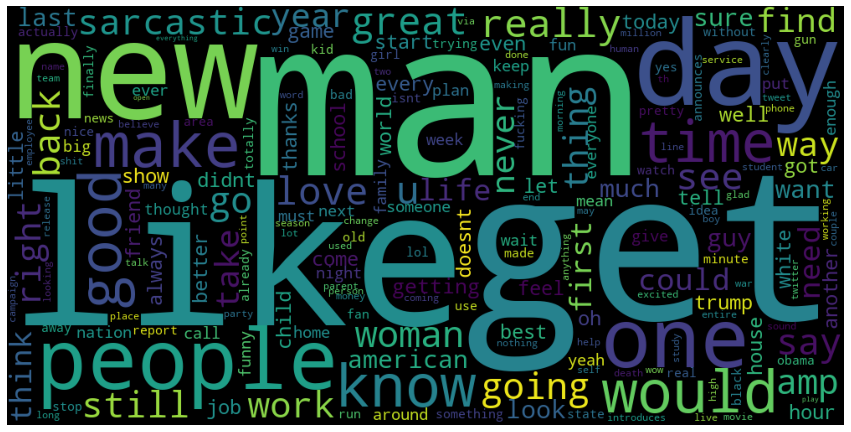

In [94]:
sarc_data = data.loc[(data['is_sarcastic'] == 1),['clean_text']]
data_words = ''
for text in sarc_data.clean_text:
  data_words += ','.join(map(str, text))

word_dict = Counter(data_words.split(','))

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 999.5, 499.5, -0.5)

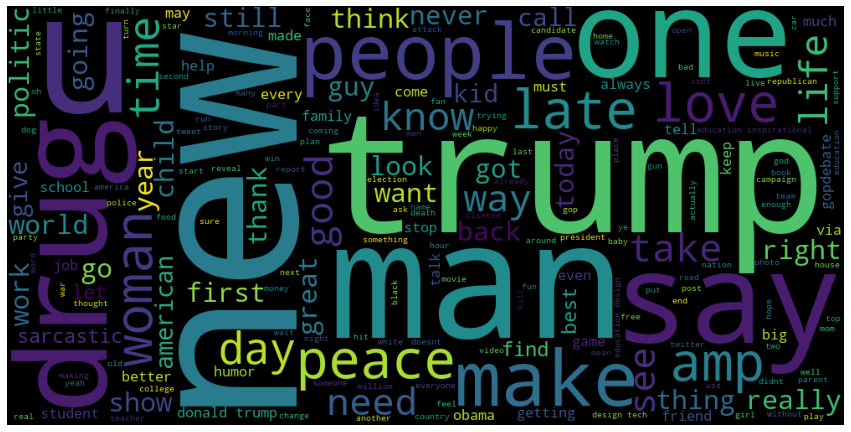

In [95]:
sarc_data = data.loc[(data['is_sarcastic'] == 1),['clean_text']]
data_words = ''
for text in data.clean_text:
  data_words += ','.join(map(str, text))

wordcloud = WordCloud(width = 1000, height = 500).generate(data_words)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [98]:
# clip the size of the text to 100 rather than taking the whole text

data_split = 0.2
max_length = 100

tokenizer_object = Tokenizer()

tokenizer_object.fit_on_texts(data['clean_text'])
#print(tokenizer_object.word_counts)
data_sequences = tokenizer_object.texts_to_sequences(data['clean_text'])
#print(sequences)

max_text_length = 0
for i in range(len(data_sequences)):
    if max_text_length <= len(data_sequences[i]):
        max_text_length = len(data_sequences[i])
print('Max length --> ', max_text_length)

word_index = tokenizer_object.word_index
print('Unique Words --> ', len(word_index))

padded_data = pad_sequences(data_sequences, maxlen = max_length, padding='post')
output_data = data['is_sarcastic'].values
indices = np.arange(padded_data.shape[0])
np.random.shuffle(indices)
padded_data = padded_data[indices]
output_data = output_data[indices]

num_test_data = int(data_split * padded_data.shape[0])
X_train = padded_data[:-num_test_data]
y_train = output_data[:-num_test_data]
X_test = padded_data[-num_test_data:]
y_test = output_data[-num_test_data:]

Max length -->  106
Unique Words -->  68781


In [99]:
print('Shape of X_train_pad:', X_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (78855, 100)
Shape of y_train: (78855,)
Shape of X_test_pad: (19713, 100)
Shape of y_test: (19713,)


In [100]:
# Load Glove Model

glove_embedding = {}
glove_dimension = 100

GLOVE_DIR = 'C:/05pythonworkspace/glove/twitter'
file = open(os.path.join(GLOVE_DIR,'glove.twitter.27B.100d.txt'),'r',encoding='utf-8')
for line in file:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],dtype='float32')
    glove_embedding[word] = vector
file.close()

print('Found %s word vectors.' % len(glove_embedding))

Found 1193514 word vectors.


In [101]:
embedded_data = np.zeros((len(word_index)+1, glove_dimension))
count = 0
for word, i in word_index.items():
    embedding_vector =glove_embedding.get(word)
    if embedding_vector is not None:
        count+=1
        embedded_data[i] = embedding_vector

print(embedded_data.shape)

(68782, 100)


In [102]:
embedding_layer = Embedding(len(word_index)+1, glove_dimension, weights=[embedded_data], input_length=max_length, trainable=False)

In [103]:
## Build attention layer
class attention(Layer):
    def __init__(self, **kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name = 'attn_weight', shape=(input_shape[-1],1), initializer='normal')
        self.b = self.add_weight(name='attn_bias', shape=(input_shape[1],1), initializer='zeros')
        super(attention,self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x, self.W)+self.b),axis=1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention, self).get_config()

In [104]:
class ATTENTION(Layer):
    def __init__(self,**kwargs):
        super(ATTENTION,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(ATTENTION, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(ATTENTION,self).get_config()

In [105]:
from keras import Input
from keras.models import Model
from tensorflow import keras

inputs = Input(shape=(max_length,))
x = Embedding(input_dim=len(word_index)+1,output_dim=32,
             input_length=max_length,embeddings_regularizer=keras.regularizers.l2(.001))(inputs)

att_in=LSTM(64,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)
att_out = ATTENTION()(att_in)
outputs=Dense(1,activation='sigmoid', trainable=True)(att_out)
model=Model(inputs,outputs)
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 32)           2201024   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           24832     
                                                                 
 attention (ATTENTION)       (None, 64)                164       
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,226,085
Trainable params: 2,226,085
Non-trainable params: 0
_________________________________________________________________


In [106]:
#training
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_test, y_test), verbose=2)

Epoch 1/15
2465/2465 - 210s - loss: 0.7036 - acc: 0.5095 - val_loss: 0.6929 - val_acc: 0.5132 - 210s/epoch - 85ms/step
Epoch 2/15
2465/2465 - 213s - loss: 0.6930 - acc: 0.5112 - val_loss: 0.6928 - val_acc: 0.5132 - 213s/epoch - 86ms/step
Epoch 3/15
2465/2465 - 224s - loss: 0.6930 - acc: 0.5108 - val_loss: 0.6929 - val_acc: 0.5132 - 224s/epoch - 91ms/step
Epoch 4/15
2465/2465 - 228s - loss: 0.6874 - acc: 0.5310 - val_loss: 0.5795 - val_acc: 0.7578 - 228s/epoch - 93ms/step
Epoch 5/15
2465/2465 - 234s - loss: 0.5175 - acc: 0.8234 - val_loss: 0.4642 - val_acc: 0.8572 - 234s/epoch - 95ms/step
Epoch 6/15
2465/2465 - 233s - loss: 0.4545 - acc: 0.8630 - val_loss: 0.4413 - val_acc: 0.8707 - 233s/epoch - 94ms/step
Epoch 7/15
2465/2465 - 237s - loss: 0.4365 - acc: 0.8751 - val_loss: 0.4292 - val_acc: 0.8793 - 237s/epoch - 96ms/step
Epoch 8/15
2465/2465 - 232s - loss: 0.4262 - acc: 0.8799 - val_loss: 0.4233 - val_acc: 0.8805 - 232s/epoch - 94ms/step
Epoch 9/15
2465/2465 - 232s - loss: 0.4194 - acc

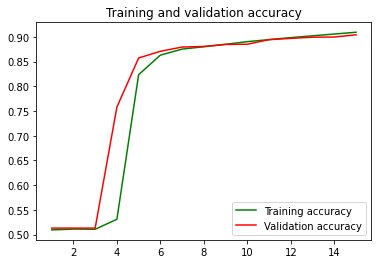

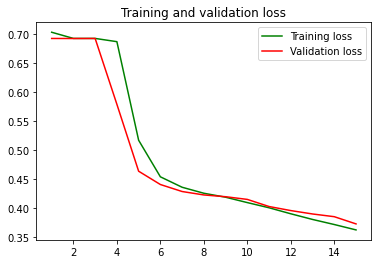

In [107]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()